In [1]:
import argparse
import os
import random
import shutil
import time
import warnings
import math
import numpy as np
from PIL import ImageOps, Image
import tempfile

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn.functional as F

from torchvision.utils import save_image

from tqdm import tqdm

import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
  
import torch
import torch.nn as nn
from torchvision.models.utils import load_state_dict_from_url


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        c1 = self.conv1(x)
        b1 = self.bn1(c1)
        a1 = self.relu(b1)

        c2 = self.conv2(a1)
        b2 = self.bn2(c2)
        out = b2

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out, [c1, b1, a1, c2, b2]



class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        acts_layer1 = []
        for block in self.layer1:
            # print("Block in layer 1")
            x, acts_block = block(x)
            acts_layer1.append(acts_block)
            
        acts_layer2 = []
        for block in self.layer2:
            # print("Block in layer 2")
            x, acts_block = block(x)
            acts_layer2.append(acts_block)

        acts_layer3 = []
        for block in self.layer3:
            # print("Block in layer 3")
            x, acts_block = block(x)
            acts_layer3.append(acts_block)

        acts_layer4 = []
        for block in self.layer4:
            # print("Block in layer 4")
            x, acts_block = block(x)
            acts_layer4.append(acts_block)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x, [acts_layer1, acts_layer2, acts_layer3, acts_layer4]

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

In [3]:
print("=> creating model")
model = resnet18(pretrained=True)
print(model)

=> creating model
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReL

In [4]:
imagenet_train = datasets.ImageFolder(
    "/var/tmp/namespace/hendrycks/imagenet/val/",
    transform=transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        )
    ])
)

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        # The normalize code -> t.sub_(m).div_(s)
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unnorm = UnNormalize(
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225]
)
    
def show_image(img, plt):
    img = img.permute((1,2,0))
    npimg = np.asarray(img)
    print(npimg.shape)
    plt.imshow(npimg, interpolation='nearest')

Layer 3, Block 1, Act 0
Step 0
tensor(0.5373, grad_fn=<MeanBackward0>) tensor(7.2033, grad_fn=<NllLossBackward>)
tensor([468])
tensor([463])
Step 1
tensor(0.3879, grad_fn=<MeanBackward0>) tensor(7.2127, grad_fn=<NllLossBackward>)
tensor([468])
tensor([463])
Step 2
tensor(0.3053, grad_fn=<MeanBackward0>) tensor(7.2135, grad_fn=<NllLossBackward>)
tensor([468])
tensor([463])
Step 3
tensor(0.2554, grad_fn=<MeanBackward0>) tensor(7.2083, grad_fn=<NllLossBackward>)
tensor([468])
tensor([463])
Step 4
tensor(0.2042, grad_fn=<MeanBackward0>) tensor(7.1556, grad_fn=<NllLossBackward>)
tensor([468])
tensor([463])
Step 5
tensor(0.1669, grad_fn=<MeanBackward0>) tensor(7.2025, grad_fn=<NllLossBackward>)
tensor([468])
tensor([463])
Step 6
tensor(0.1435, grad_fn=<MeanBackward0>) tensor(7.2403, grad_fn=<NllLossBackward>)
tensor([468])
tensor([463])
Step 7
tensor(0.1204, grad_fn=<MeanBackward0>) tensor(7.2352, grad_fn=<NllLossBackward>)
tensor([468])
tensor([463])
Step 8
tensor(0.1055, grad_fn=<MeanBackw

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0937, grad_fn=<MeanBackward0>) tensor(7.2530, grad_fn=<NllLossBackward>)
tensor([468])
tensor([463])
(229, 224, 3)
(229, 224, 3)


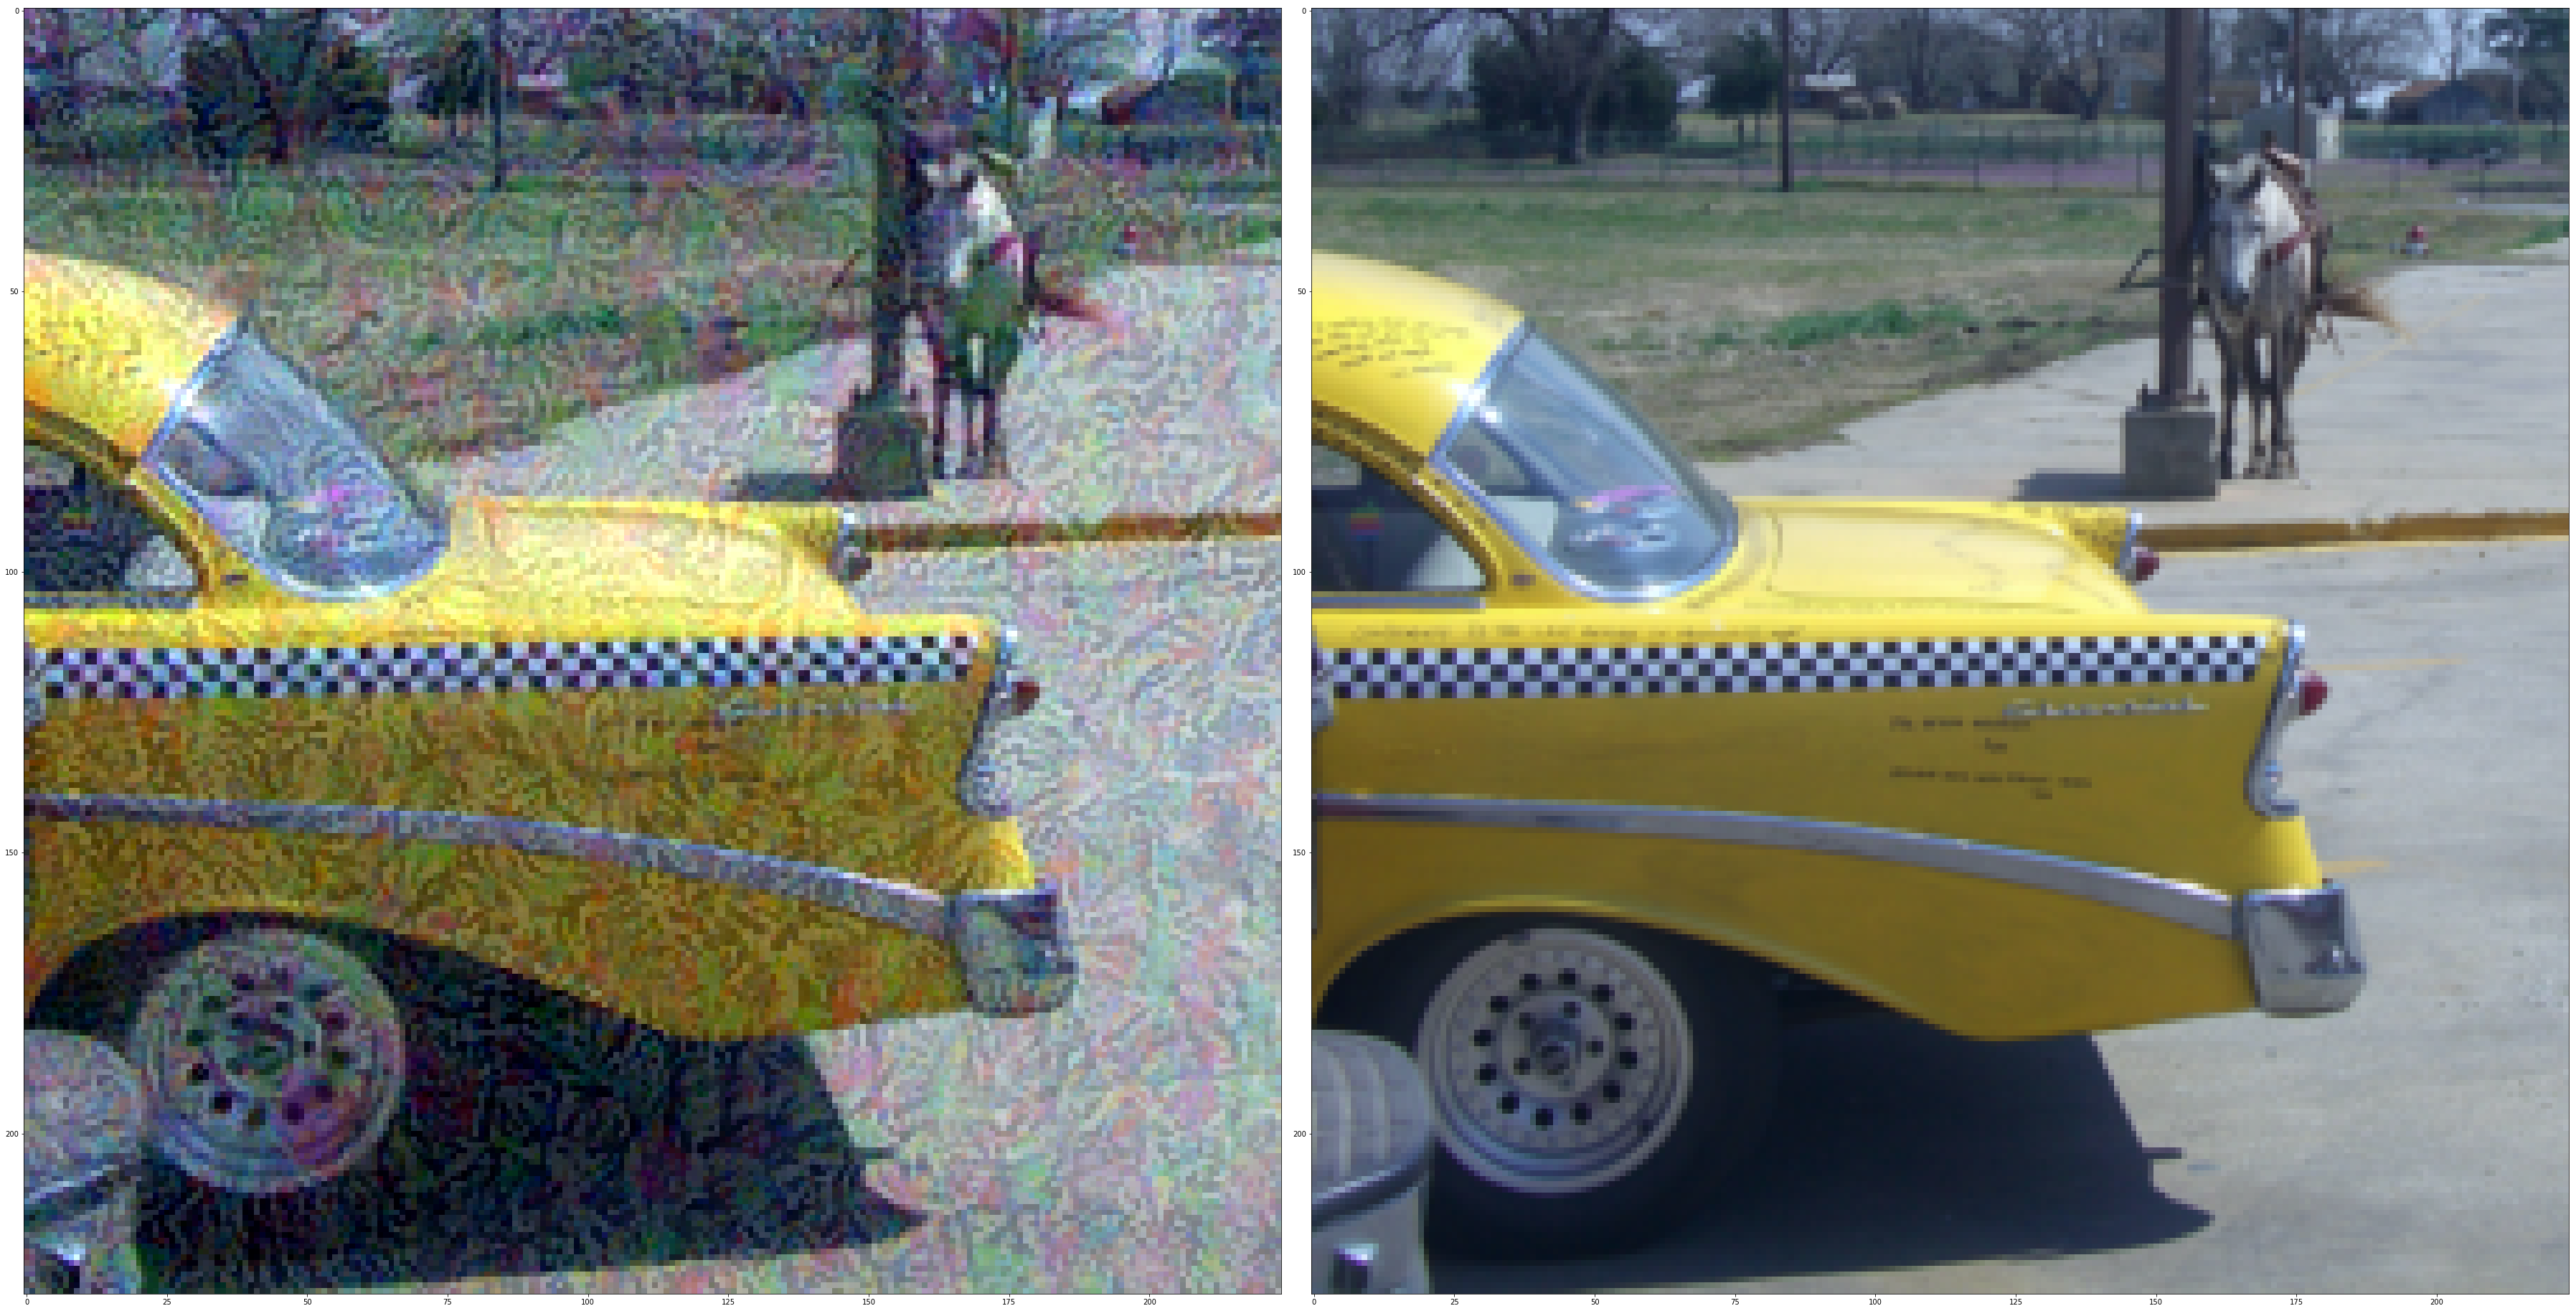

In [5]:
# rand_image = (torch.rand((1, 3, 224, 224)) * 2) - 1
rand_image = imagenet_train[23423][0].unsqueeze(0)
rand_image_target = torch.tensor(imagenet_train[23423][1]).unsqueeze(0)
rand_image.requires_grad = True
original_image = unnorm(rand_image.clone().detach())
logits, (acts_layer1, acts_layer2, acts_layer3, acts_layer4) = model(rand_image)

# All activations
(l1_b1_c1, l1_b1_b1, l1_b1_a1, l1_b1_c2, l1_b1_b2), (l1_b2_c1, l1_b2_b1, l1_b2_a1, l1_b2_c2, l1_b2_b2) = acts_layer1
(l2_b1_c1, l2_b1_b1, l2_b1_a1, l2_b1_c2, l2_b1_b2), (l2_b2_c1, l2_b2_b1, l2_b2_a1, l2_b2_c2, l2_b2_b2) = acts_layer2
(l3_b1_c1, l3_b1_b1, l3_b1_a1, l3_b1_c2, l3_b1_b2), (l3_b2_c1, l3_b2_b1, l3_b2_a1, l3_b2_c2, l3_b2_b2) = acts_layer3
(l4_b1_c1, l4_b1_b1, l4_b1_a1, l4_b1_c2, l4_b1_b2), (l4_b2_c1, l4_b2_b1, l4_b2_a1, l4_b2_c2, l4_b2_b2) = acts_layer4

optimizer = torch.optim.Adam([rand_image], lr=0.07, weight_decay=1e-6)

# Random Options
rand_layer = random.randint(0, 3)
rand_block = random.randint(0, 1)
rand_act = random.randint(0, 4)
rand_channel = None

print(f"Layer {rand_layer}, Block {rand_block}, Act {rand_act}")

for n in range(10):  # optimize pixel values for opt_steps times
    print(f"Step {n}")
    optimizer.zero_grad()
    logits, (acts_layer1, acts_layer2, acts_layer3, acts_layer4) = model(rand_image)
    all_acts = [acts_layer1, acts_layer2, acts_layer3, acts_layer4]

    # All activations
    # (l1_b1_c1, l1_b1_b1, l1_b1_a1, l1_b1_c2, l1_b1_b2), (l1_b2_c1, l1_b2_b1, l1_b2_a1, l1_b2_c2, l1_b2_b2) = acts_layer1
    # (l2_b1_c1, l2_b1_b1, l2_b1_a1, l2_b1_c2, l2_b1_b2), (l2_b2_c1, l2_b2_b1, l2_b2_a1, l2_b2_c2, l2_b2_b2) = acts_layer2
    # (l3_b1_c1, l3_b1_b1, l3_b1_a1, l3_b1_c2, l3_b1_b2), (l3_b2_c1, l3_b2_b1, l3_b2_a1, l3_b2_c2, l3_b2_b2) = acts_layer3
    # (l4_b1_c1, l4_b1_b1, l4_b1_a1, l4_b1_c2, l4_b1_b2), (l4_b2_c1, l4_b2_b1, l4_b2_a1, l4_b2_c2, l4_b2_b2) = acts_layer4
    
    # lX_bY_cN is shape [batch_size, C, W, H]
    act_map = all_acts[rand_layer][rand_block][rand_act]
    rand_channel = torch.max(torch.mean(act_map, dim=(2, 3)), dim=1)[1].item()
    # if rand_channel == None:
    #     rand_channel = random.randint(0, act_map.shape[1] - 1)
    loss = (act_map[:, :, :, :] ** 2).mean()
    loss.backward()
    optimizer.step()

    logits = model(rand_image)[0]
    print(loss, F.cross_entropy(logits, rand_image_target))
    print(rand_image_target)
    print(logits.max(1)[1])

denormed = unnorm(rand_image)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(50, 50)
fig.tight_layout()
show_image(denormed[0].detach(), ax[0])
show_image(original_image[0].detach(), ax[1])


Layer 2, Block 1, Act 3
Step 0
tensor(0.0495, grad_fn=<MulBackward0>) tensor(10.2907, grad_fn=<NllLossBackward>)
tensor([468])
tensor([556])
Step 1
tensor(0.0216, grad_fn=<MulBackward0>) tensor(7.4950, grad_fn=<NllLossBackward>)
tensor([468])
tensor([556])
Step 2
tensor(0.0137, grad_fn=<MulBackward0>) tensor(7.6899, grad_fn=<NllLossBackward>)
tensor([468])
tensor([556])
Step 3
tensor(0.0098, grad_fn=<MulBackward0>) tensor(7.4601, grad_fn=<NllLossBackward>)
tensor([468])
tensor([556])
Step 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0076, grad_fn=<MulBackward0>) tensor(7.1337, grad_fn=<NllLossBackward>)
tensor([468])
tensor([556])
(229, 224, 3)
(229, 224, 3)


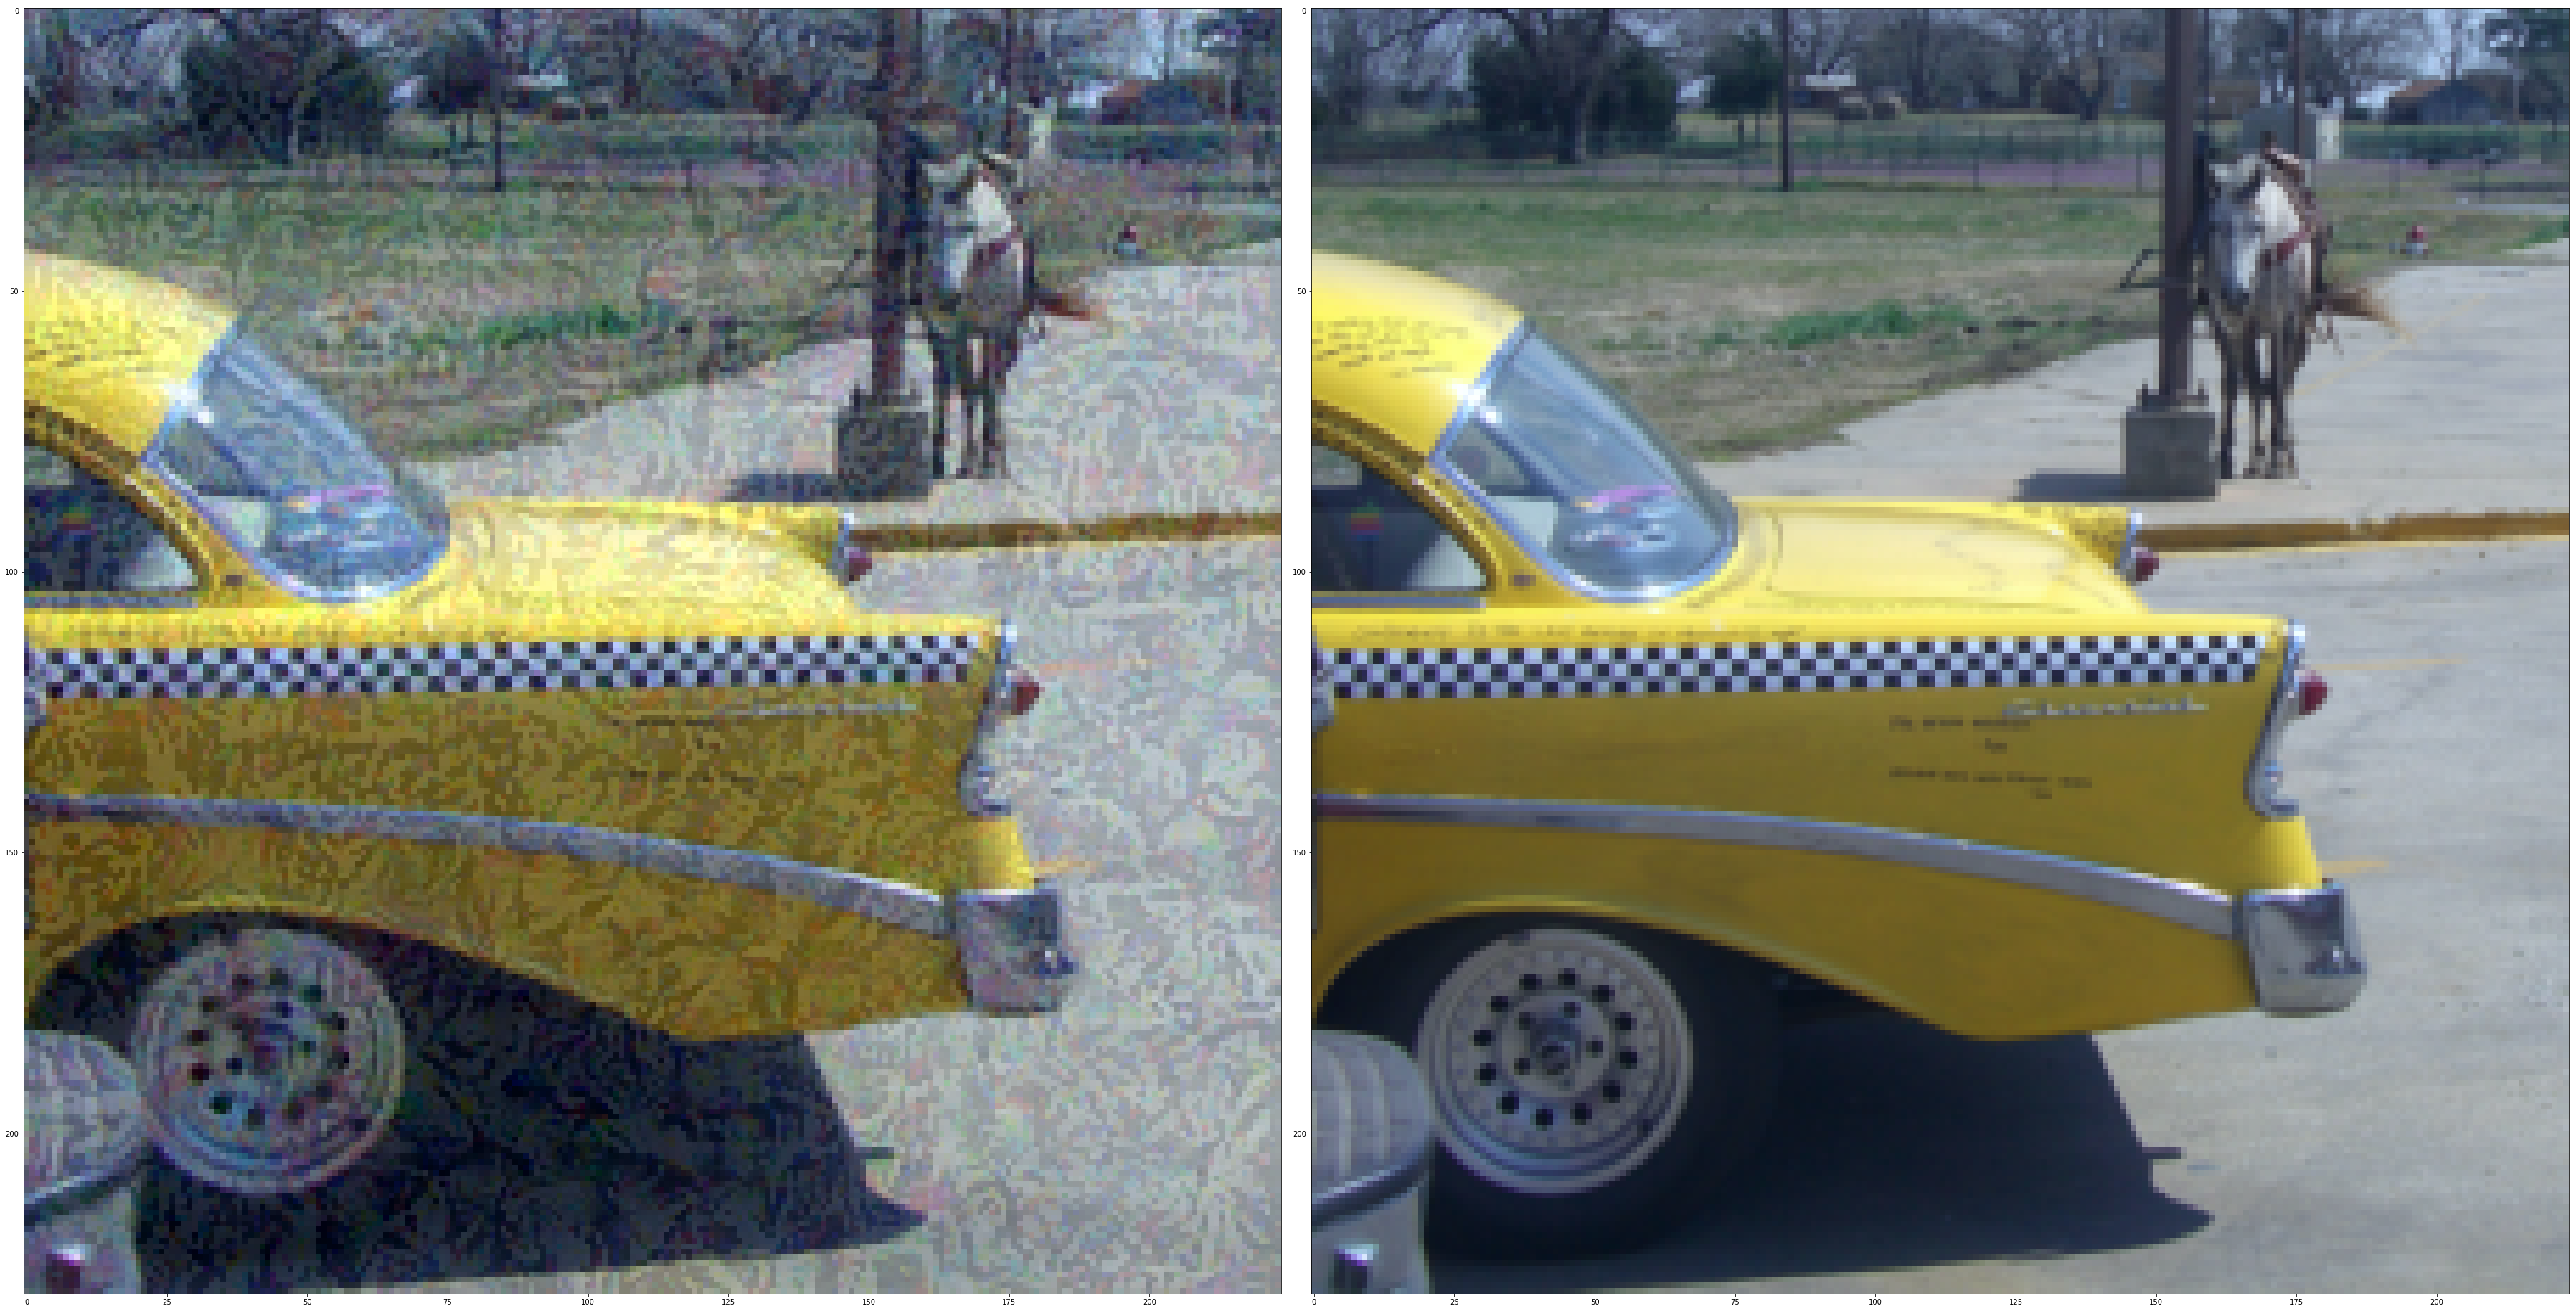

In [26]:
# rand_image = (torch.rand((1, 3, 224, 224)) * 2) - 1
model.eval()
rand_image = imagenet_train[23423][0].unsqueeze(0)
rand_image_target = torch.tensor(imagenet_train[23423][1]).unsqueeze(0)
rand_image.requires_grad = True
original_image = unnorm(rand_image.clone().detach())
logits, (acts_layer1, acts_layer2, acts_layer3, acts_layer4) = model(rand_image)

# All activations
(l1_b1_c1, l1_b1_b1, l1_b1_a1, l1_b1_c2, l1_b1_b2), (l1_b2_c1, l1_b2_b1, l1_b2_a1, l1_b2_c2, l1_b2_b2) = acts_layer1
(l2_b1_c1, l2_b1_b1, l2_b1_a1, l2_b1_c2, l2_b1_b2), (l2_b2_c1, l2_b2_b1, l2_b2_a1, l2_b2_c2, l2_b2_b2) = acts_layer2
(l3_b1_c1, l3_b1_b1, l3_b1_a1, l3_b1_c2, l3_b1_b2), (l3_b2_c1, l3_b2_b1, l3_b2_a1, l3_b2_c2, l3_b2_b2) = acts_layer3
(l4_b1_c1, l4_b1_b1, l4_b1_a1, l4_b1_c2, l4_b1_b2), (l4_b2_c1, l4_b2_b1, l4_b2_a1, l4_b2_c2, l4_b2_b2) = acts_layer4

# all_convs = [
#     l1_b1_c1,
#     l2_b1_c1,
#     l3_b1_c1,
#     l4_b1_c1,
#     l1_b1_c2,
#     l2_b1_c2,
#     l3_b1_c2,
#     l4_b1_c2,
#     l1_b2_c1,
#     l2_b2_c1,
#     l3_b2_c1,
#     l4_b2_c1,
#     l1_b2_c2,
#     l2_b2_c2,
#     l3_b2_c2,
#     l4_b2_c2,
# ]
# for c in all_convs:
#     c.retain_grad()
# logits.max(1)[0].backward()

# for i, c in enumerate(all_convs):
#     print(i, torch.mean(c.grad ** 2))

optimizer = torch.optim.Adam([rand_image], lr=0.07, weight_decay=1e-6)

# Random Options
rand_layer = random.randint(0, 3)
rand_block = random.randint(0, 1)
rand_act = random.randint(0, 4)
rand_channel = None

print(f"Layer {rand_layer}, Block {rand_block}, Act {rand_act}")

for n in range(5):  # optimize pixel values for opt_steps times
    print(f"Step {n}")
    optimizer.zero_grad()
    logits, (acts_layer1, acts_layer2, acts_layer3, acts_layer4) = model(rand_image)
    all_acts = [acts_layer1, acts_layer2, acts_layer3, acts_layer4]

    # All activations
    # (l1_b1_c1, l1_b1_b1, l1_b1_a1, l1_b1_c2, l1_b1_b2), (l1_b2_c1, l1_b2_b1, l1_b2_a1, l1_b2_c2, l1_b2_b2) = acts_layer1
    # (l2_b1_c1, l2_b1_b1, l2_b1_a1, l2_b1_c2, l2_b1_b2), (l2_b2_c1, l2_b2_b1, l2_b2_a1, l2_b2_c2, l2_b2_b2) = acts_layer2
    # (l3_b1_c1, l3_b1_b1, l3_b1_a1, l3_b1_c2, l3_b1_b2), (l3_b2_c1, l3_b2_b1, l3_b2_a1, l3_b2_c2, l3_b2_b2) = acts_layer3
    # (l4_b1_c1, l4_b1_b1, l4_b1_a1, l4_b1_c2, l4_b1_b2), (l4_b2_c1, l4_b2_b1, l4_b2_a1, l4_b2_c2, l4_b2_b2) = acts_layer4
    
    # lX_bY_cN is shape [batch_size, C, W, H]
    act_map = all_acts[rand_layer][rand_block][rand_act]
    # rand_channel = torch.max(torch.mean(act_map, dim=(2, 3)), dim=1)[1].item()
    # if rand_channel == None:
    #     rand_channel = random.randint(0, act_map.shape[1] - 1)
    loss = 1 * (act_map[:, :, :, :] ** 2).mean()
    loss.backward()
    optimizer.step()

    logits = model(rand_image)[0]
    print(loss, F.cross_entropy(logits, rand_image_target))
    print(rand_image_target)
    print(logits.max(1)[1])

denormed = unnorm(rand_image)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(50, 50)
fig.tight_layout()
show_image(denormed[0].detach(), ax[0])
show_image(original_image[0].detach(), ax[1])
